# Switchpoint analysis for coal mining disasters

The goal is to generate coal mining accident data set so that the true model is known.
Based on the generated observations, PyMC3 is used to approximate the true model and spot the switchpoint where the rate of accidents was changed due to policy changes.

This is an adapted version of [PyMC3 tutorial case](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters)

## Generation of observation dataset

The dataset contains count of accidents per annum, let's say from 1900 to 2000. Let's say that policymakers set new safety regulations for mining companies in 1950 which reduced accidents drastically.
So year 1950 will be our switchpoint in the rate of mining accidents. The switchpoint year is the hidden information which we are trying to figure out. When we know when the rate of accidents changed, we can further investigate what could have caused the change. In our simulated case, it'd be the regulations. The idea of the switchpoint detection is the same for all kinds of count data processes.

Because we are modeling the count of events in a fixed time interval (accident count per year), we are dealing with Poisson distributed data where Poisson parameter $\lambda$ changes after year 1950 so we have
two values for $\lambda$

$$
D_t \sim Pois(r_t), r_t =
\begin{cases}
e \text{ if } t \le s \\
l \text{ if } t \gt s
\end{cases}
$$

$$
\text{Prior distributions for parameters} \\
s \sim Unif(t_l, t_h) \\
e \sim Exp(1) \\
l \sim Exp(1)
$$

Let's generate data with true parameters $e$ and $l$

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from matplotlib import pyplot as plt
import arviz as az

In [2]:
tl = 1900
th = 2000
real_switchpoint = 1950

e = 3.0 # $lambda before year 1950
l = 1.0	# $lambda after year 1950

In [3]:
def generate_dataset(e, l, first_year, last_year, switchpoint):
	years = np.arange(first_year, last_year)
	counts = np.concatenate((np.random.poisson(e, switchpoint - first_year),
							np.random.poisson(l, last_year - switchpoint)))

	return pd.DataFrame(data=list(zip(years, counts)),
						columns=['year', 'accident_count'])

In [4]:
data = generate_dataset(e, l, tl, th, real_switchpoint)
data

,year,accident_count
0,1900,3
1,1901,5
2,1902,4
3,1903,4
4,1904,5
...,...,...
95,1995,0
96,1996,1
97,1997,2
98,1998,4


## Data exploration

<AxesSubplot:xlabel='year', ylabel='accident_count'>

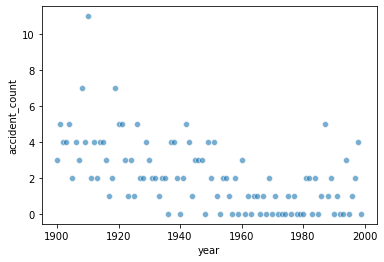

In [5]:
sns.lineplot(x=data['year'], y=data['accident_count'], data=data, marker='o', linestyle='', alpha=0.6)

<BarContainer object of 100 artists>

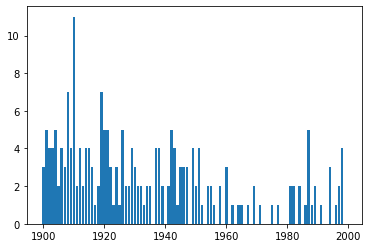

In [6]:
plt.bar(data['year'], data['accident_count'])

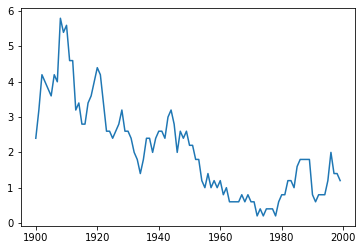

In [7]:
N = 5
five_year_moving_average = np.convolve(data['accident_count'], np.ones(N)/N, mode='same')

plt.plot(data['year'], five_year_moving_average)

The 5-year moving average already shows that there's a significant change around 1950. Because the change is so significant, the change can easily be detected from visualisations.
Subtle changes usually require more analytical operations to be spotted.

## MCMC inference
Let's try to infer true rates $e$ and $l$ with more precise switchpoint year

In [8]:
with pm.Model() as model:
	# Priors for the rates
	# Exponential distribution was chosen because it's restricted to [0, infinity]
	# There cannot be negative accidents
	e = pm.Exponential('early_mean', 1.0)
	l = pm.Exponential('late_mean', 1.0)

	# Set test value to the starting year
	# It sets all the distributions to start from there and the sampling will also start from there
	# Use uniform as a prior to assign equal weight to each year
	switchpoint = pm.DiscreteUniform('switchpoint', tl, th)

	# If we had a good guess about how significant the change is,
	# we could limit uncertainty by introducing extra term to likelihood function
	# which max difference of rates impossible to be more than 3 units
	# e_l_max_difference = pm.Potential('e-l-max', e - l < 3)

	# How many accidents per yea
	# Wrap in deterministic variable so that we can see it in the posterior results
	rate = pm.Deterministic('rate', pm.math.switch(switchpoint >= data['year'], e, l))
	disasters = pm.Poisson('disasters', rate, observed=data['accident_count'])

	trace = pm.sample(10000)


<ipython-input-8-9a3d0923e03d>:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [late_mean, early_mean]
>Metropolis: [switchpoint]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 10 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [9]:
with model:
	inferred_data = az.from_pymc3(trace)

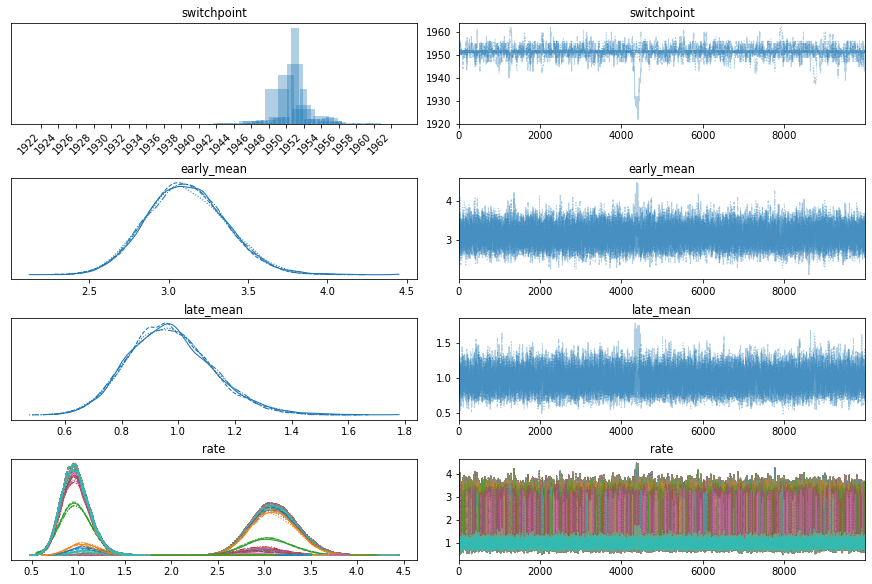

In [10]:
with model:
	axes_arr = az.plot_trace(trace)

for ax in axes_arr.flatten():
	if ax.get_title() == "switchpoint":
		labels = [label.get_text() for label in ax.get_xticklabels()]
		ax.set_xticklabels(ax.get_xticks(), rotation=45, ha="right")
		break

plt.draw()

In [11]:
with model:
    summary = az.summary(trace, round_to=2)
    display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint,1951.25,2.36,1947.00,1955.00,0.09,0.07,1439.84,1235.80,1.0
early_mean,3.11,0.25,2.64,3.57,0.00,0.00,13486.59,10556.90,1.0
late_mean,0.97,0.15,0.69,1.25,0.00,0.00,6798.47,3740.42,1.0
rate[0],3.11,0.25,2.64,3.57,0.00,0.00,13486.59,10556.90,1.0
rate[1],3.11,0.25,2.64,3.57,0.00,0.00,13486.59,10556.90,1.0
...,...,...,...,...,...,...,...,...,...
rate[95],0.97,0.15,0.69,1.25,0.00,0.00,6798.47,3740.42,1.0
rate[96],0.97,0.15,0.69,1.25,0.00,0.00,6798.47,3740.42,1.0
rate[97],0.97,0.15,0.69,1.25,0.00,0.00,6798.47,3740.42,1.0
rate[98],0.97,0.15,0.69,1.25,0.00,0.00,6798.47,3740.42,1.0


/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'switchpoint'}>,
       <AxesSubplot:title={'center':'early_mean'}>,
       <AxesSubplot:title={'center':'late_mean'}>], dtype=object)

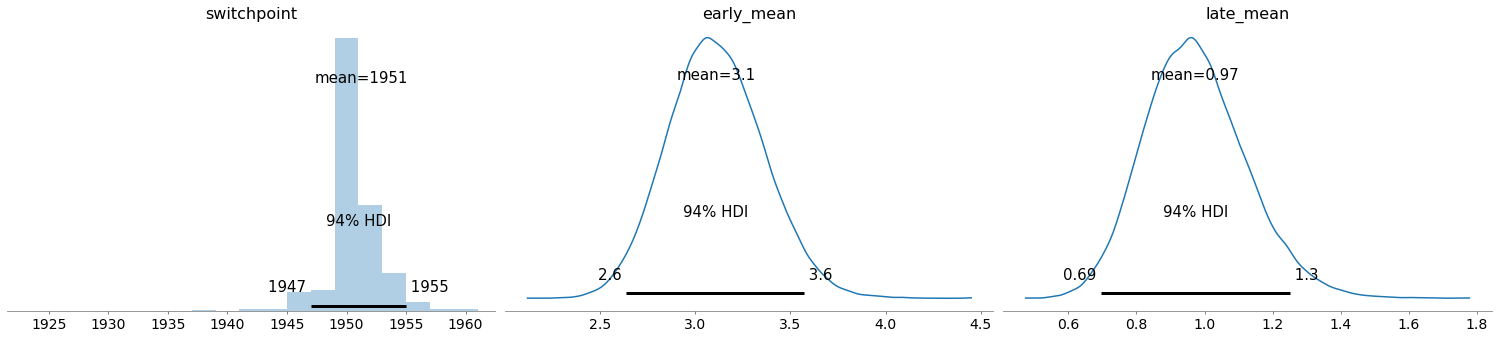

In [12]:
az.plot_posterior(trace, ['switchpoint', 'early_mean', 'late_mean'])

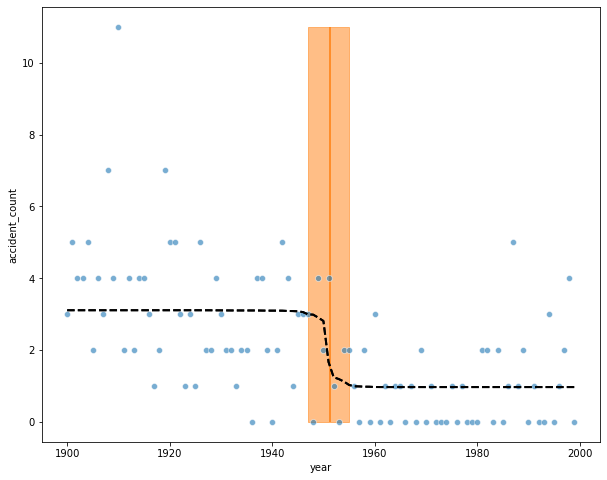

In [13]:
plt.figure(figsize=(10, 8))

sns.lineplot(x=data['year'], y=data['accident_count'], data=data, marker='o', linestyle='', alpha=0.6)

plt.vlines(trace["switchpoint"].mean(), data['accident_count'].min(), data['accident_count'].max(), color="C1")
average_disasters = np.zeros_like(data, dtype="float")

for i, year in enumerate(data['year']):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_mean"], trace["late_mean"]))
 
sp_hpd = az.hdi(trace["switchpoint"])
plt.fill_betweenx(
    y=[data['accident_count'].min(), data['accident_count'].max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(data['year'], average_disasters, "k--", lw=2)

## Convergence tests

/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
<ipython-input-14-96d3d477ff5d>:5: DeprecationWarning: The function `energyplot` from PyMC3 is just an alias for `plot_energy` from ArviZ. Please switch to `pymc3.plot_energy` or `arviz.plot_energy`.
  pm.energyplot(trace, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr))


Text(0.5, 1.0, 'BFMI = [0.70433897 0.70071387 0.84077501 0.75098273]\nGelman-Rubin = 1.0')

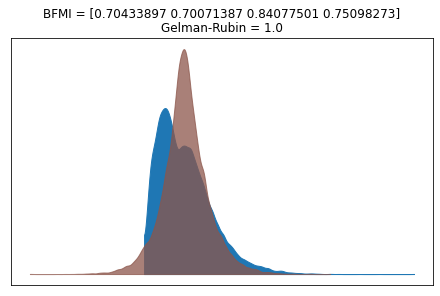

In [14]:
# BFMI & Gelman-Rubin
# Both BFMI and Gelman-Rubin should be close to 1.0 if posterior exploration has converged
bfmi = az.bfmi(trace)
max_gr = max(np.max(gr_stats) for gr_stats in summary['r_hat'])
pm.energyplot(trace, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr))

In [15]:
# display the total number and percentage of divergent
divergent = trace["diverging"]
print("Number of Divergent %d" % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(trace) * 100
print("Percentage of Divergent %.1f" % divperc)

Number of Divergent 0
Percentage of Divergent 0.0


It seems the model converged without any issues.

## Non-existing switchpoint

Let's calculate Bayes factor to check how much more likely it's that there's a switchpoint vs. there is no switchpoint at all.

In [25]:
# Calculate Bayes factor directly with Pymc3
# For this, we need to use Sequential Monte Carlo sampling

# Same model as above byt with SMC sampling
with pm.Model() as model_smc:
	e = pm.Exponential('early_mean', 1.0)
	l = pm.Exponential('late_mean', 1.0)

	switchpoint = pm.DiscreteUniform('switchpoint', tl, th)

	rate = pm.Deterministic('rate', pm.math.switch(switchpoint >= data['year'], e, l))
	disasters = pm.Poisson('disasters', rate, observed=data['accident_count'])

	trace = pm.sample_smc(1000, parallel=True)


Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.013
Stage:   1 Beta: 0.048
Stage:   2 Beta: 0.116
Stage:   3 Beta: 0.252
Stage:   4 Beta: 0.513
Stage:   5 Beta: 0.960
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.013
Stage:   1 Beta: 0.048
Stage:   2 Beta: 0.116
Stage:   3 Beta: 0.253
Stage:   4 Beta: 0.515
Stage:   5 Beta: 0.962
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.013
Stage:   1 Beta: 0.048
Stage:   2 Beta: 0.118
Stage:   3 Beta: 0.260
Stage:   4 Beta: 0.522
Stage:   5 Beta: 0.975
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.013
Stage:   1 Beta: 0.048
Stage:   2 Beta: 0.117
Stage:   3 Beta: 0.255
Stage:   4 Beta: 0.517
Stage:   5 Beta: 0.966
Stage:   6 Beta: 1.000


In [26]:
with pm.Model() as no_switchpoint:
	rate = pm.Exponential('rate_no_switchpoint', 1.0)
	disasters = pm.Poisson('disasters_no_switchpoint', rate, observed=data['accident_count'])
	trace_no_switchpoint = pm.sample_smc(1000, parallel=True)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.016
Stage:   1 Beta: 0.117
Stage:   2 Beta: 0.867
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.016
Stage:   1 Beta: 0.117
Stage:   2 Beta: 0.859
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.015
Stage:   1 Beta: 0.117
Stage:   2 Beta: 0.857
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.016
Stage:   1 Beta: 0.121
Stage:   2 Beta: 0.900
Stage:   3 Beta: 1.000


In [28]:
BF_smc = np.exp(trace.report.log_marginal_likelihood - trace_no_switchpoint.report.log_marginal_likelihood)
np.round(BF_smc)

array([4.55454251e+10, 4.35946745e+10, 4.50024946e+10, 4.28409351e+10])

Each sampling trace is giving a likelihood ratio of ~4.5. This ratio suggests that the switchpoint model is substantially more likely than no switchpoint at all.
As a conclusion, the hypothesis about the existence of a switchpoint is strongly backed by Bayes factor.

### Model accuracy
Bayes factor measures the explainability power of the model whereas WAIC / LOO measures how accurate predictions the model can result.

In [36]:
cmp_df = az.compare({
	'switchpoint': trace,
	'no-switchpoint': trace_no_switchpoint
}, method='BB-pseudo-BMA', ic='waic')

cmp_df

/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarni

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
switchpoint,0,-174.590189,4.703502,0.000000,0.998527,10.070842,0.000000,True,log
no-switchpoint,1,-202.381961,1.800528,27.791772,0.001473,11.640927,8.401928,False,log


Because waic is in log scale, higher value implies better model prediction accuracy.

Switchpoint p_waic tells how flexible the model is, in other words how many effective parameters it has. More parameters, more flexibility but also more danger to overfit the data.
Information criteria uses effective number of parameters as a penalization term for the model. The goal is to find the simplest model possible to explain the data. More parameters introduces more penalization because the simplicity of the model is reduced.

Switchpoint model returned warning for waic which means the computation of WAIC might not be reliable.

<AxesSubplot:xlabel='Log'>

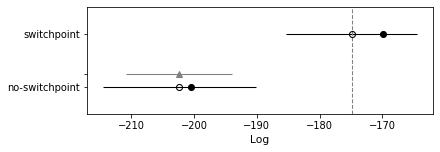

In [33]:
az.plot_compare(cmp_df)